# TODO!!!! Run nestedcross.rerun_nested_for_estimator on calibrated instances to get a good comparison of how they would perform!

# Setup, matplotlib inline, automatically reload libraries on every evaluation

In [75]:
import pandas as pd
import numpy as np
import scipy as sp
import matplotlib.pyplot as plt
pd.options.display.max_rows = 400
pd.options.display.max_columns = 400
%matplotlib inline
%load_ext autoreload
%autoreload 2

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [61]:
from loadcreon import LoadCreon
from creonmetrics import pu_scorer, prior_squared_error_scorer_015, brier_score_labeled_loss_scorer, \
    f1_assumed_scorer, f1_labeled_scorer, report_metrics, f1_assumed_beta10_scorer
from semisuperhelper import SemiSupervisedHelper
from pnuwrapper import PNUWrapper
from jeffsearchcv import JeffRandomSearchCV
from nestedcross import NestedCV
from frankenscorer import FrankenScorer, extract_scores_from_nested, extract_score_grid
from searchrf import save_search, load_search
from repeatedsampling import RepeatedRandomSubSampler
from blagging import BlaggingClassifier

In [3]:
path = "C:\Data\\010317\membership14_final_0103.txt"
lc = LoadCreon(path)

In [66]:
from sklearn.model_selection import train_test_split
from sklearn.calibration import CalibratedClassifierCV, calibration_curve
from sklearn.ensemble import RandomForestClassifier
from sklearn.base import clone

In [5]:
X_train, X_test, y_train, y_test = train_test_split(lc.X, lc.y, test_size=0.2, random_state=42, stratify=lc.y)

## Set up best RF model

In [6]:
pnu = PNUWrapper(base_estimator=RandomForestClassifier(n_jobs=-1), random_state=None)

In [7]:
pnu.set_params(**{'base_estimator__class_weight': 'balanced',
  'base_estimator__max_depth': 80,
  'base_estimator__max_features': None,
  'base_estimator__min_samples_leaf': 4,
  'base_estimator__min_samples_split': 0.2,
  'base_estimator__n_estimators': 294,
  'num_unlabeled': 1807,
  'pu_learning': True})

PNUWrapper(base_estimator=RandomForestClassifier(bootstrap=True, class_weight='balanced',
            criterion='gini', max_depth=80, max_features=None,
            max_leaf_nodes=None, min_impurity_split=1e-07,
            min_samples_leaf=4, min_samples_split=0.2,
            min_weight_fraction_leaf=0.0, n_estimators=294, n_jobs=-1,
            oob_score=False, random_state=None, verbose=0,
            warm_start=False),
      num_unlabeled=1807, pu_learning=True, random_state=None,
      threshold_set_pct=None)

In [8]:
pnu.fit(X_train.values, y_train.values)

PNUWrapper(base_estimator=RandomForestClassifier(bootstrap=True, class_weight='balanced',
            criterion='gini', max_depth=80, max_features=None,
            max_leaf_nodes=None, min_impurity_split=1e-07,
            min_samples_leaf=4, min_samples_split=0.2,
            min_weight_fraction_leaf=0.0, n_estimators=294, n_jobs=-1,
            oob_score=False, random_state=None, verbose=0,
            warm_start=False),
      num_unlabeled=1807, pu_learning=True, random_state=None,
      threshold_set_pct=None)

In [9]:
FrankenScorer()(pnu, X_test.values, y_test.values)

({'SCORE': 0.87531806615776087,
  'assumed_brier': 0.094377048118964413,
  'assumed_brier_neg': 0.094319200394374206,
  'assumed_f1': 0.096372040902087133,
  'assumed_f1beta10': 0.7160610869520414,
  'confusion_matrix_lab': array([[191,  24],
         [ 74, 344]]),
  'confusion_matrix_un': array([[81345,  6377],
         [   74,   344]]),
  'labeled_acc': 0.84518167456556081,
  'labeled_avg_prec': 0.93732637468199853,
  'labeled_brier': 0.12902577875674021,
  'labeled_brier_neg': 0.17278694764086469,
  'labeled_brier_pos': 0.10651704356514508,
  'labeled_f1': 0.87531806615776087,
  'labeled_prec': 0.93478260869565222,
  'labeled_recall': 0.82296650717703346,
  'labeled_roc_auc': 0.85566930010014453,
  'pr_one_unlabeled': 0.072599906293210822,
  'pu_mix_assumed_f1beta10': 80.487959472226251,
  'pu_score': 8.8818507770221036},
 0.87531806615776087)

In [138]:
def graph_prob(clf, probs=None):
    if probs is None:
        probs = clf.predict_proba(X_test.values)[:, -1]
    y_prob = pd.DataFrame(probs, columns=['pr_one'])
    y_prob['label'] = y_test.values
    y_prob['color'] = y_prob.label.map({-1:'b', 0:'r', 1:'g'})
    y_p = y_prob.sort_values(by='pr_one').reset_index(drop=True).reset_index()
    y_p_un = y_p[y_p.label==-1]
    y_p_pos = y_p[y_p.label==1]
    y_p_neg = y_p[y_p.label==0]
    ax = y_p_un.plot.scatter(x='index', y='pr_one', color='DarkBlue', s=1, label='Unlabeled')
    ax = y_p_pos.plot.scatter(x='index', y='pr_one', color='Green', s=400, ax=ax, label='Positive')
    ax.set_ylabel("Probability of Positive")
    ax.set_xlabel("# Examples")
    ax.set_title("Positive Probability of Examples")
    y_p_neg.plot.scatter(x='index', y='pr_one', color='Red', s=25, ax=ax, figsize=(20, 10), 
                         xlim=(0, 90000), ylim=(0, 1), label='Negative')
    plt.legend(loc="upper left")
    plt.show()

In [145]:
def simple_cal_plot(clf, c=1.0):
    y_test_assumed = y_test.values.copy()
    y_test_assumed[y_test_assumed==-1] = 0
    fraction_of_positives, mean_predicted_value = calibration_curve(y_test_assumed,
                                                                    clf.predict_proba(X_test.values)[:,-1] / c,
                                                                    n_bins=20, normalize=True)
    fig, ax = plt.subplots()
    ax.plot(mean_predicted_value, fraction_of_positives, "s-")
    ax.set_ylabel("Fraction of positives")
    ax.set_ylim([-0.05, 1.05])
    ax.set_title('Calibration plots')
    ax.set_xlabel('Mean predicted value')
    plt.show()

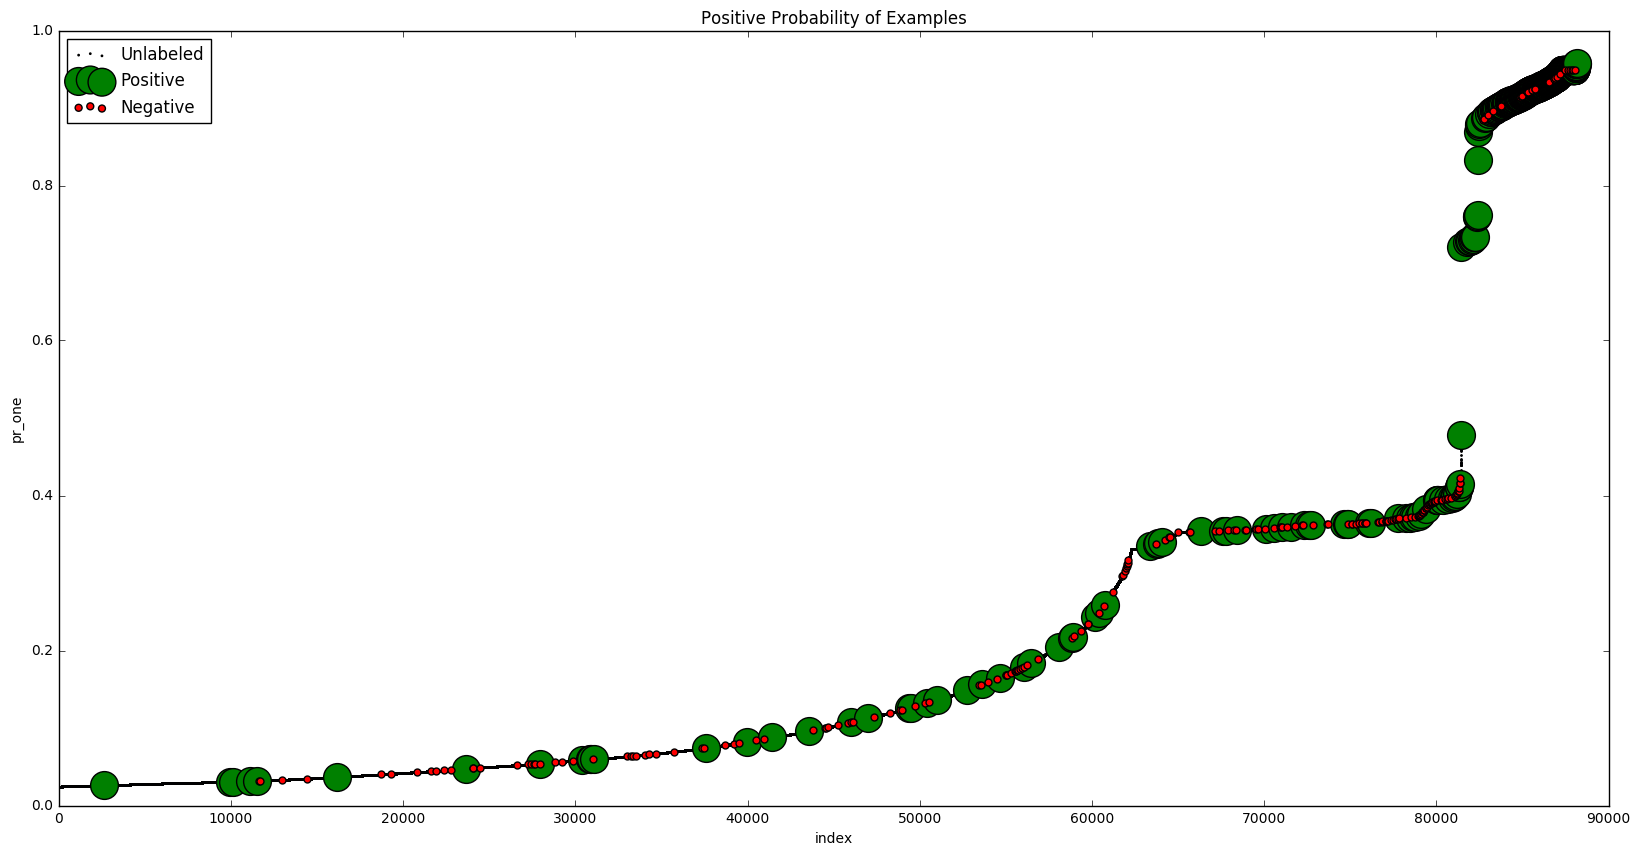

In [178]:
graph_prob(pnu)

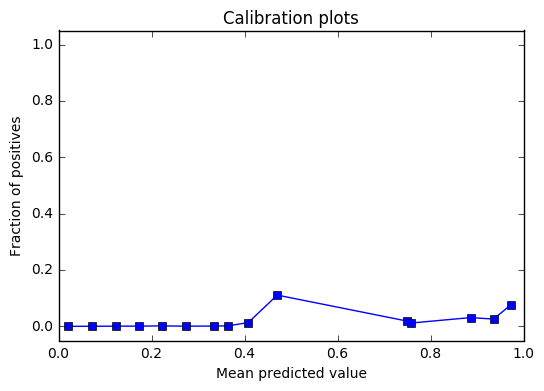

In [179]:
simple_cal_plot(pnu)

## Calibration isotonic regression

In [91]:
rf = clone(pnu.base_estimator)
cal_rf = CalibratedClassifierCV(base_estimator=rf, method='isotonic', cv=2)
cal_iso = clone(pnu).set_params(base_estimator=cal_rf)

In [92]:
cal_iso.fit(X_train.values, y_train.values)

PNUWrapper(base_estimator=CalibratedClassifierCV(base_estimator=RandomForestClassifier(bootstrap=True, class_weight='balanced',
            criterion='gini', max_depth=80, max_features=None,
            max_leaf_nodes=None, min_impurity_split=1e-07,
            min_samples_leaf=4, min_samples_split=0.2,
            min_weight_fraction_leaf=0.0, n_estimators=294, n_jobs=-1,
            oob_score=False, random_state=None, verbose=0,
            warm_start=False),
            cv=2, method='isotonic'),
      num_unlabeled=1807, pu_learning=True, random_state=None,
      threshold_set_pct=None)

In [93]:
FrankenScorer()(cal_iso, X_test.values, y_test.values)

({'SCORE': 0.85342789598108748,
  'assumed_brier': 0.093354441659838694,
  'assumed_brier_neg': 0.09331510924971885,
  'assumed_f1': 0.076224662162162171,
  'assumed_f1beta10': 0.71697408266803009,
  'confusion_matrix_lab': array([[148,  67],
         [ 57, 361]]),
  'confusion_matrix_un': array([[79029,  8693],
         [   57,   361]]),
  'labeled_acc': 0.80410742496050558,
  'labeled_avg_prec': 0.89857085046326313,
  'labeled_brier': 0.13985687508333838,
  'labeled_brier_neg': 0.21421826806236077,
  'labeled_brier_pos': 0.10160879017786036,
  'labeled_f1': 0.85342789598108748,
  'labeled_prec': 0.84345794392523366,
  'labeled_recall': 0.86363636363636365,
  'labeled_roc_auc': 0.77600422832980975,
  'pr_one_unlabeled': 0.09857497114516553,
  'pu_mix_assumed_f1beta10': 78.958374151933,
  'pu_score': 7.2609658851299912},
 0.85342789598108748)

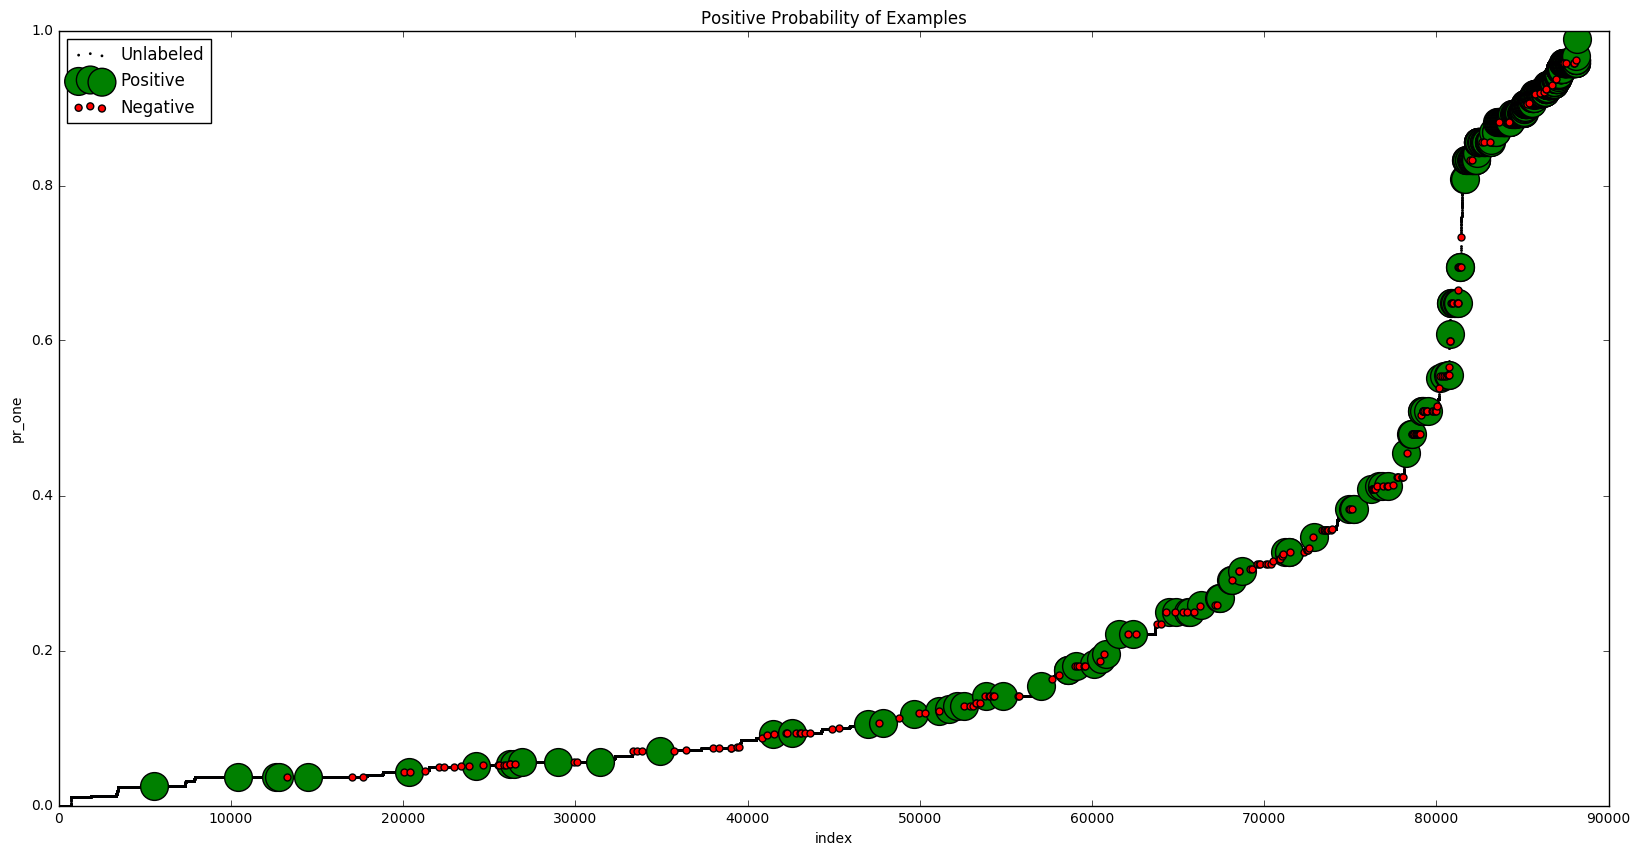

In [176]:
graph_prob(cal_iso)

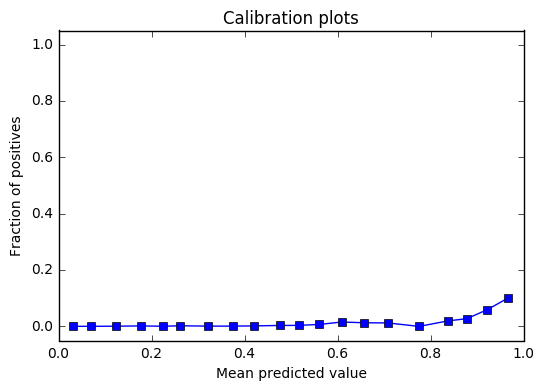

In [177]:
simple_cal_plot(cal_iso)

## Calibration platt scaling (sigmoid)

In [98]:
rf = clone(pnu.base_estimator)
cal_rf_sig = CalibratedClassifierCV(base_estimator=rf, method='sigmoid', cv=2)
cal_sig = clone(pnu).set_params(base_estimator=cal_rf_sig)

In [99]:
cal_sig.fit(X_train.values, y_train.values)

PNUWrapper(base_estimator=CalibratedClassifierCV(base_estimator=RandomForestClassifier(bootstrap=True, class_weight='balanced',
            criterion='gini', max_depth=80, max_features=None,
            max_leaf_nodes=None, min_impurity_split=1e-07,
            min_samples_leaf=4, min_samples_split=0.2,
            min_weight_fraction_leaf=0.0, n_estimators=294, n_jobs=-1,
            oob_score=False, random_state=None, verbose=0,
            warm_start=False),
            cv=2, method='sigmoid'),
      num_unlabeled=1807, pu_learning=True, random_state=None,
      threshold_set_pct=None)

In [100]:
FrankenScorer()(cal_sig, X_test.values, y_test.values)

({'SCORE': 0.87563451776649759,
  'assumed_brier': 0.087549105550591033,
  'assumed_brier_neg': 0.087442596690899585,
  'assumed_f1': 0.09619406106231701,
  'assumed_f1beta10': 0.71763978992894639,
  'confusion_matrix_lab': array([[190,  25],
         [ 73, 345]]),
  'confusion_matrix_un': array([[81312,  6410],
         [   73,   345]]),
  'labeled_acc': 0.84518167456556081,
  'labeled_avg_prec': 0.9365575693837106,
  'labeled_brier': 0.12593875931097467,
  'labeled_brier_neg': 0.15711878294812356,
  'labeled_brier_pos': 0.10990118734449855,
  'labeled_f1': 0.87563451776649759,
  'labeled_prec': 0.93243243243243246,
  'labeled_recall': 0.82535885167464118,
  'labeled_roc_auc': 0.85453989095359972,
  'pr_one_unlabeled': 0.072965591324122642,
  'pu_mix_assumed_f1beta10': 80.652578105860044,
  'pu_score': 8.8885991129654052},
 0.87563451776649759)

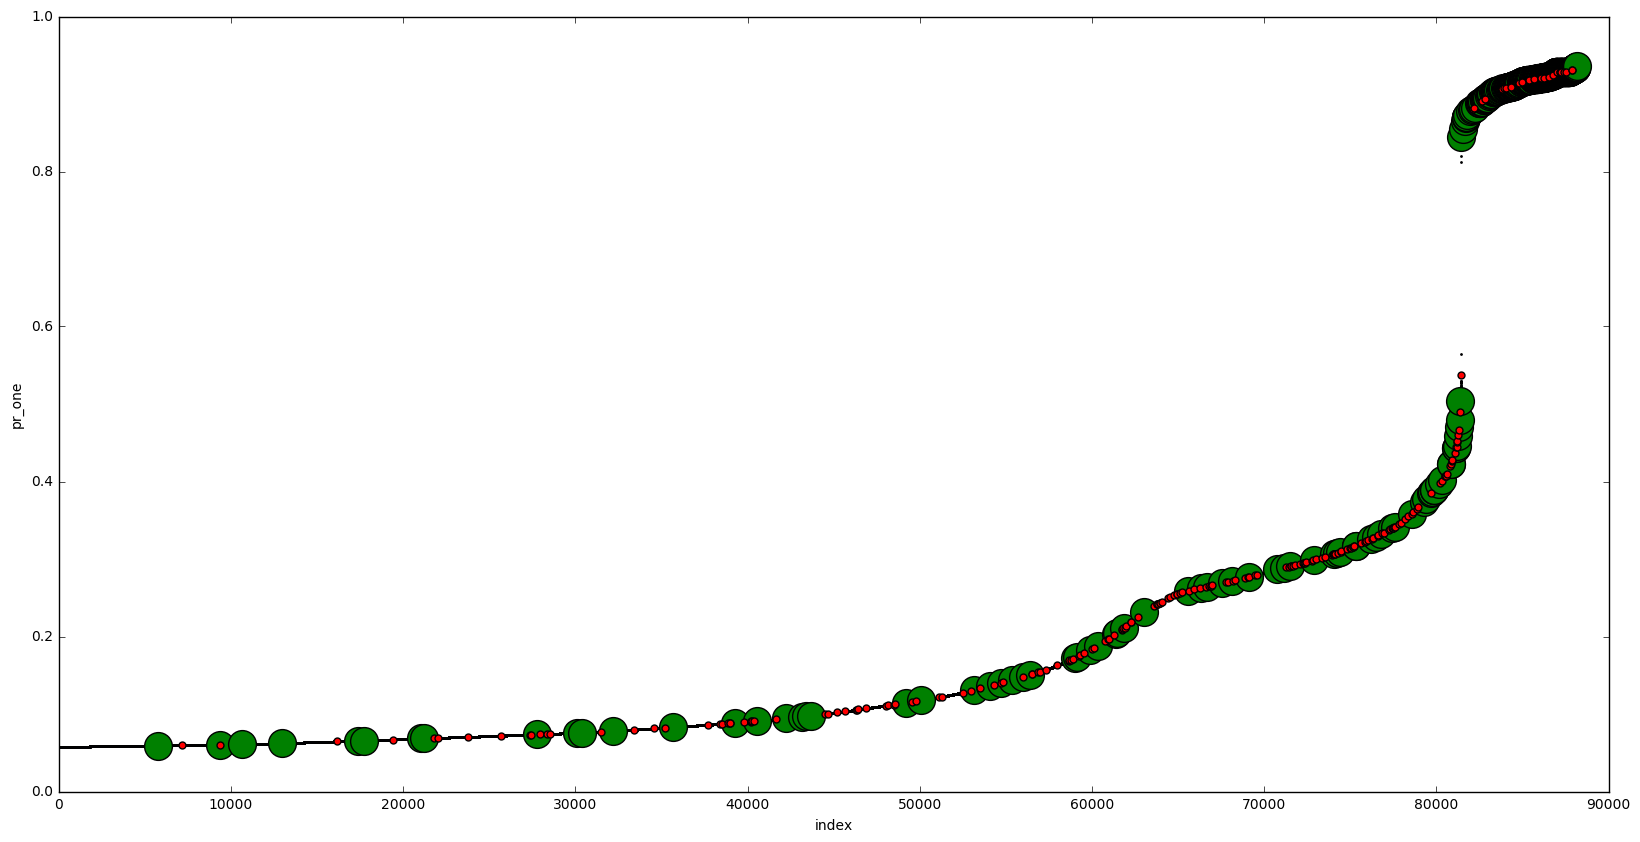

In [103]:
graph_prob(cal_sig)

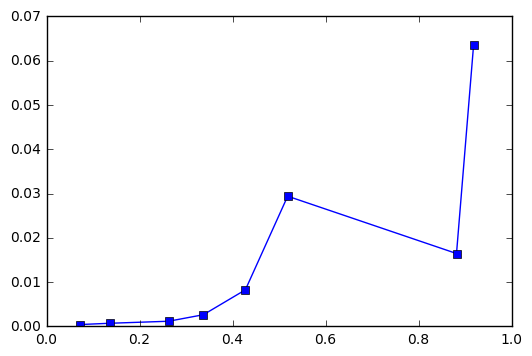

In [104]:
simple_cal_plot(cal_sig)

## lets look at Blagging

In [62]:
blag = PNUWrapper(base_estimator=BlaggingClassifier(base_estimator=RandomForestClassifier(
    n_estimators=300, max_depth=80, class_weight='balanced', max_features=None, min_samples_leaf=4, min_samples_split=0.2), 
                                                    n_estimators=20, max_samples=5000, sample_imbalance=0.8, bootstrap=True,
                                                    n_jobs=-1, verbose=1),
                  num_unlabeled=1.0, pu_learning=False)

In [63]:
blag.fit(X_train.values, y_train.values)

[Parallel(n_jobs=4)]: Done   2 out of   4 | elapsed:  1.6min remaining:  1.6min
[Parallel(n_jobs=4)]: Done   4 out of   4 | elapsed:  1.7min finished


PNUWrapper(base_estimator=BlaggingClassifier(base_estimator=RandomForestClassifier(bootstrap=True, class_weight='balanced',
            criterion='gini', max_depth=80, max_features=None,
            max_leaf_nodes=None, min_impurity_split=1e-07,
            min_samples_leaf=4, min_samples_split=0.2,
          ...ore=False,
          random_state=None, sample_imbalance=0.8, verbose=1,
          warm_start=False),
      num_unlabeled=1.0, pu_learning=True, random_state=None,
      threshold_set_pct=None)

In [55]:
FrankenScorer()(blag, X_test.values, y_test.values)

[Parallel(n_jobs=4)]: Done   2 out of   4 | elapsed:   10.0s remaining:   10.0s
[Parallel(n_jobs=4)]: Done   4 out of   4 | elapsed:   11.0s finished
[Parallel(n_jobs=4)]: Done   2 out of   4 | elapsed:    9.9s remaining:    9.9s
[Parallel(n_jobs=4)]: Done   4 out of   4 | elapsed:   11.0s finished


({'SCORE': 0.79543292102759267,
  'assumed_brier': 0.98348379151456466,
  'assumed_brier_neg': 0.98816997642809146,
  'assumed_f1': 0.0094401409245917917,
  'assumed_f1beta10': 0.324903801754656,
  'confusion_matrix_lab': array([[  0, 215],
         [  0, 418]]),
  'confusion_matrix_un': array([[    0, 87722],
         [    0,   418]]),
  'labeled_acc': 0.66034755134281198,
  'labeled_avg_prec': 0.83017377567140604,
  'labeled_brier': 0.33565759368198489,
  'labeled_brier_neg': 0.98816997642809201,
  'labeled_brier_pos': 3.5195858030144627e-05,
  'labeled_f1': 0.79543292102759267,
  'labeled_prec': 0.66034755134281198,
  'labeled_recall': 1.0,
  'labeled_roc_auc': 0.5,
  'pr_one_unlabeled': 1.0,
  'pu_mix_assumed_f1beta10': 33.490380175465603,
  'pu_score': 1.0},
 0.79543292102759267)

In [57]:
[est.predict(X_test.values[0:4]) for est in blag.base_estimator.estimators_]

[array([1, 1, 1, 1], dtype=int64),
 array([1, 1, 1, 1], dtype=int64),
 array([1, 1, 1, 1], dtype=int64),
 array([1, 1, 1, 1], dtype=int64),
 array([1, 1, 1, 1], dtype=int64),
 array([1, 1, 1, 1], dtype=int64),
 array([1, 1, 1, 1], dtype=int64),
 array([1, 1, 1, 1], dtype=int64),
 array([1, 1, 1, 1], dtype=int64),
 array([1, 1, 1, 1], dtype=int64),
 array([1, 1, 1, 1], dtype=int64),
 array([1, 1, 1, 1], dtype=int64),
 array([1, 1, 1, 1], dtype=int64),
 array([1, 1, 1, 1], dtype=int64),
 array([1, 1, 1, 1], dtype=int64),
 array([1, 1, 1, 1], dtype=int64),
 array([1, 1, 1, 1], dtype=int64),
 array([1, 1, 1, 1], dtype=int64),
 array([1, 1, 1, 1], dtype=int64),
 array([1, 1, 1, 1], dtype=int64)]

## lets look at best repeated random model

In [123]:
rr_params = {'base_estimator__base_estimator': RandomForestClassifier(bootstrap=True, class_weight=None, criterion='gini',
              max_depth=64, max_features='auto', max_leaf_nodes=None,
              min_impurity_split=1e-07, min_samples_leaf=1,
              min_samples_split=2, min_weight_fraction_leaf=0.0,
              n_estimators=10, n_jobs=1, oob_score=False, random_state=None,
              verbose=0, warm_start=False),
  'base_estimator__base_estimator__bootstrap': False,
  'base_estimator__base_estimator__class_weight': None,
  'base_estimator__base_estimator__criterion': 'gini',
  'base_estimator__base_estimator__max_depth': 64,
  'base_estimator__base_estimator__max_features': 87,
  'base_estimator__base_estimator__min_samples_leaf': 8,
  'base_estimator__base_estimator__min_samples_split': 0.01,
  'base_estimator__base_estimator__n_estimators': 79,
  'base_estimator__sample_imbalance': 0.44063408204723742,
  'pu_learning': True}

In [124]:
rf = RandomForestClassifier()
rep = RepeatedRandomSubSampler(base_estimator=rf, verbose=1, n_jobs=-1)
pnu_rep = PNUWrapper(base_estimator=rep, num_unlabeled=1.0)
pnu_rep.set_params(**rr_params)

PNUWrapper(base_estimator=RepeatedRandomSubSampler(base_estimator=RandomForestClassifier(bootstrap=False, class_weight=None, criterion='gini',
            max_depth=64, max_features=87, max_leaf_nodes=None,
            min_impurity_split=1e-07, min_samples_leaf=1,
            min_samples_split=0.01, min_weight...obs', random_state=None,
             sample_imbalance=0.4406340820472374, verbose=1, voting='hard'),
      num_unlabeled=1.0, pu_learning=True, random_state=None,
      threshold_set_pct=None)

In [125]:
pnu_rep.fit(X_train.values, y_train.values)

generating 93 samples of indices to use to train multiple estimators,               sized 5459 elements with last being 3106 elements


[Parallel(n_jobs=-1)]: Done  42 tasks      | elapsed:   16.7s
[Parallel(n_jobs=-1)]: Done  93 out of  93 | elapsed:   35.0s finished


PNUWrapper(base_estimator=RepeatedRandomSubSampler(base_estimator=RandomForestClassifier(bootstrap=False, class_weight=None, criterion='gini',
            max_depth=64, max_features=87, max_leaf_nodes=None,
            min_impurity_split=1e-07, min_samples_leaf=1,
            min_samples_split=0.01, min_weight...obs', random_state=None,
             sample_imbalance=0.4406340820472374, verbose=1, voting='hard'),
      num_unlabeled=1.0, pu_learning=True, random_state=None,
      threshold_set_pct=None)

In [126]:
FrankenScorer()(pnu_rep, X_test.values, y_test.values)

[Parallel(n_jobs=-1)]: Done  42 tasks      | elapsed:   16.0s
[Parallel(n_jobs=-1)]: Done  93 out of  93 | elapsed:   34.7s finished
[Parallel(n_jobs=-1)]: Done  42 tasks      | elapsed:   16.2s
[Parallel(n_jobs=-1)]: Done  93 out of  93 | elapsed:   34.8s finished


({'SCORE': 0.88040712468193394,
  'assumed_brier': 0.050302896824686853,
  'assumed_brier_neg': 0.049880494741887813,
  'assumed_f1': 0.11681296421336934,
  'assumed_f1beta10': 0.7387223607998985,
  'confusion_matrix_lab': array([[193,  22],
         [ 72, 346]]),
  'confusion_matrix_un': array([[82562,  5160],
         [   72,   346]]),
  'labeled_acc': 0.85150078988941547,
  'labeled_avg_prec': 0.94085633165299021,
  'labeled_brier': 0.13637976880032915,
  'labeled_brier_neg': 0.13138524311903083,
  'labeled_brier_pos': 0.13894872339716921,
  'labeled_f1': 0.88040712468193394,
  'labeled_prec': 0.94021739130434778,
  'labeled_recall': 0.82775119617224879,
  'labeled_roc_auc': 0.86271280738845002,
  'pr_one_unlabeled': 0.058715302775777939,
  'pu_mix_assumed_f1beta10': 84.840464167398281,
  'pu_score': 10.968228087408436},
 0.88040712468193394)

[Parallel(n_jobs=-1)]: Done  42 tasks      | elapsed:   16.2s
[Parallel(n_jobs=-1)]: Done  93 out of  93 | elapsed:   34.9s finished


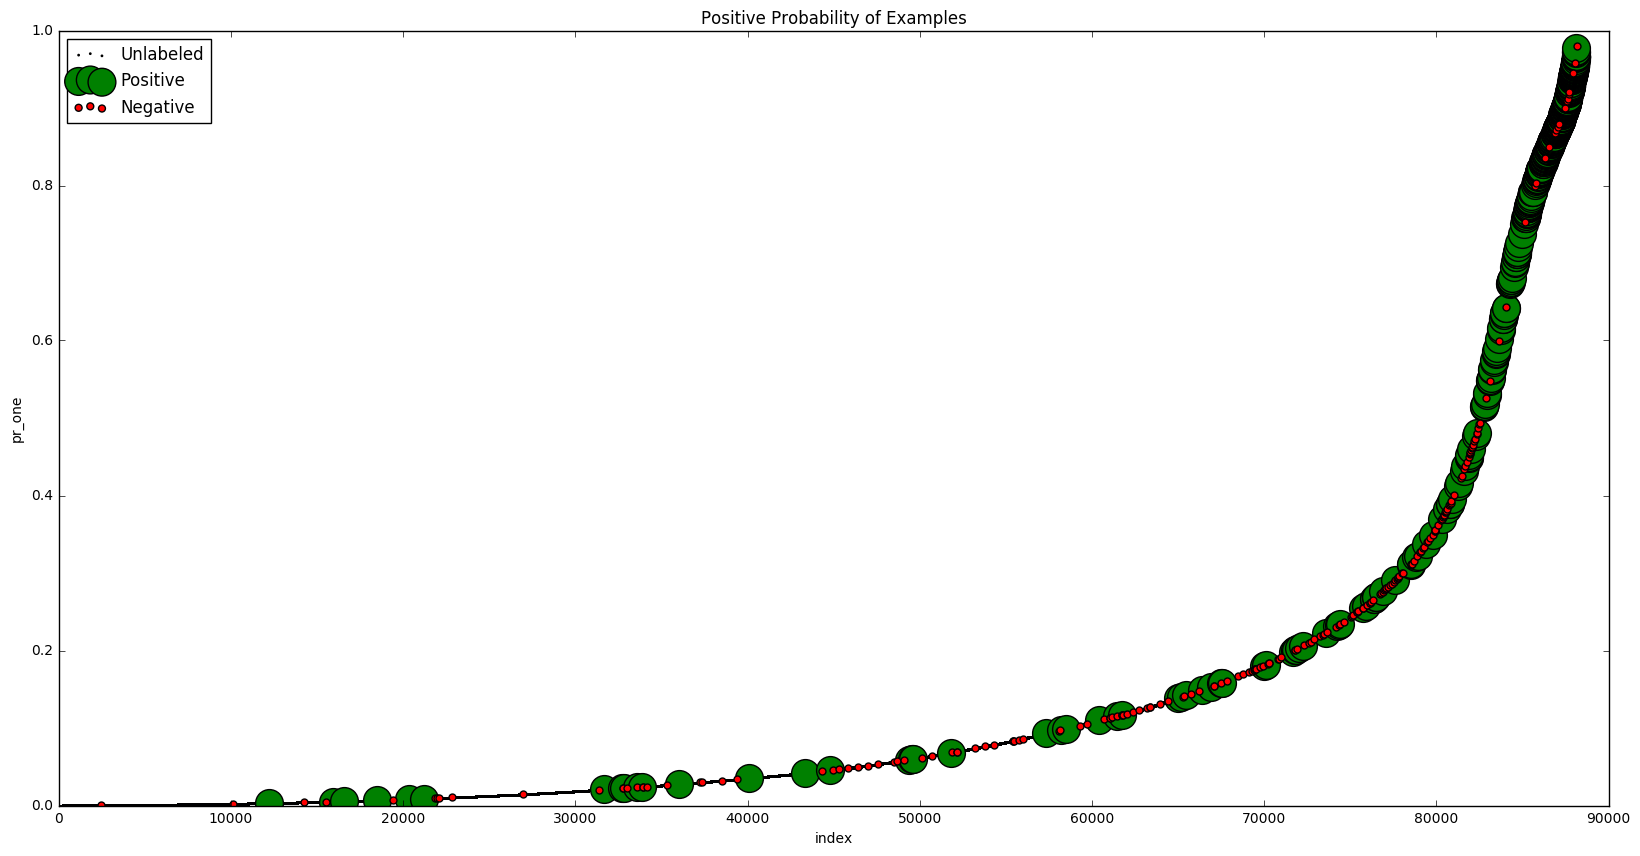

In [130]:
graph_prob(pnu_rep)

[Parallel(n_jobs=-1)]: Done  42 tasks      | elapsed:   16.3s
[Parallel(n_jobs=-1)]: Done  93 out of  93 | elapsed:   34.9s finished


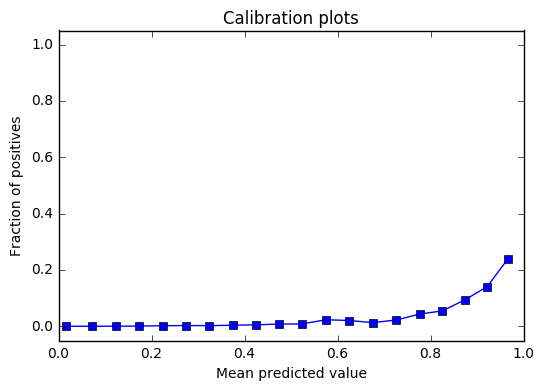

In [147]:
simple_cal_plot(pnu_rep)

## calibrate repeated random sub sampling by calibrating underlying forests

In [148]:
rf = RandomForestClassifier()
rep = RepeatedRandomSubSampler(base_estimator=rf, verbose=1, n_jobs=-1, voting='soft')
pnu_rep_rf_cal = PNUWrapper(base_estimator=rep, num_unlabeled=1.0)
pnu_rep_rf_cal.set_params(**rr_params)
pnu_rep_rf_cal.base_estimator.base_estimator = CalibratedClassifierCV(pnu_rep_rf_cal.base_estimator.base_estimator,
                                                                      method='isotonic', cv=2)

In [149]:
pnu_rep_rf_cal.fit(X_train.values, y_train.values)

generating 93 samples of indices to use to train multiple estimators,               sized 5459 elements with last being 3106 elements


[Parallel(n_jobs=-1)]: Done  42 tasks      | elapsed:   16.2s
[Parallel(n_jobs=-1)]: Done  93 out of  93 | elapsed:   30.4s finished


PNUWrapper(base_estimator=RepeatedRandomSubSampler(base_estimator=CalibratedClassifierCV(base_estimator=RandomForestClassifier(bootstrap=False, class_weight=None, criterion='gini',
            max_depth=64, max_features=87, max_leaf_nodes=None,
            min_impurity_split=1e-07, min_samples_leaf=1,
        ...obs', random_state=None,
             sample_imbalance=0.4406340820472374, verbose=1, voting='soft'),
      num_unlabeled=1.0, pu_learning=True, random_state=None,
      threshold_set_pct=None)

In [150]:
FrankenScorer()(pnu_rep_rf_cal, X_test.values, y_test.values)

[Parallel(n_jobs=-1)]: Done  42 tasks      | elapsed:   16.4s
[Parallel(n_jobs=-1)]: Done  93 out of  93 | elapsed:   35.3s finished
[Parallel(n_jobs=-1)]: Done  42 tasks      | elapsed:   16.6s
[Parallel(n_jobs=-1)]: Done  93 out of  93 | elapsed:   35.3s finished


({'SCORE': 0.87755102040816324,
  'assumed_brier': 0.046975926167710756,
  'assumed_brier_neg': 0.046504252430054627,
  'assumed_f1': 0.11786876820284392,
  'assumed_f1beta10': 0.73580550202249084,
  'confusion_matrix_lab': array([[193,  22],
         [ 74, 344]]),
  'confusion_matrix_un': array([[82647,  5075],
         [   74,   344]]),
  'labeled_acc': 0.84834123222748814,
  'labeled_avg_prec': 0.93988042552542927,
  'labeled_brier': 0.13238309710608348,
  'labeled_brier_neg': 0.10598325449012255,
  'labeled_brier_pos': 0.145961963523384,
  'labeled_f1': 0.87755102040816324,
  'labeled_prec': 0.93989071038251371,
  'labeled_recall': 0.82296650717703346,
  'labeled_roc_auc': 0.8603204628908423,
  'pr_one_unlabeled': 0.057743951912418434,
  'pu_mix_assumed_f1beta10': 84.596405354927725,
  'pu_score': 11.015855152678641},
 0.87755102040816324)

[Parallel(n_jobs=-1)]: Done  42 tasks      | elapsed:   16.7s
[Parallel(n_jobs=-1)]: Done  93 out of  93 | elapsed:   35.6s finished


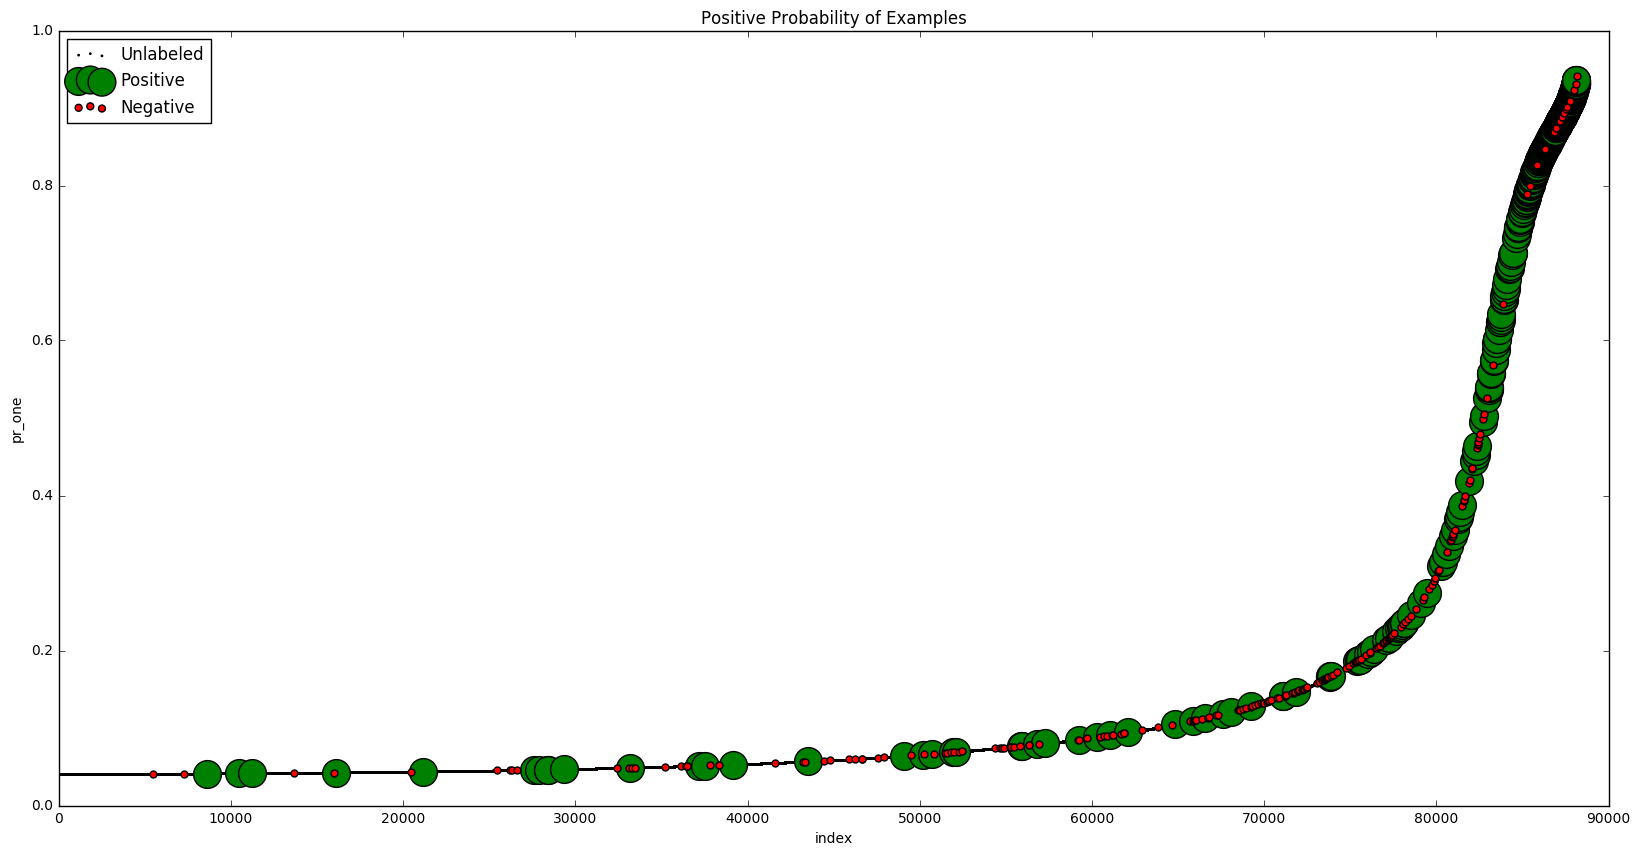

In [151]:
graph_prob(pnu_rep_rf_cal)

[Parallel(n_jobs=-1)]: Done  42 tasks      | elapsed:   16.6s
[Parallel(n_jobs=-1)]: Done  93 out of  93 | elapsed:   35.3s finished


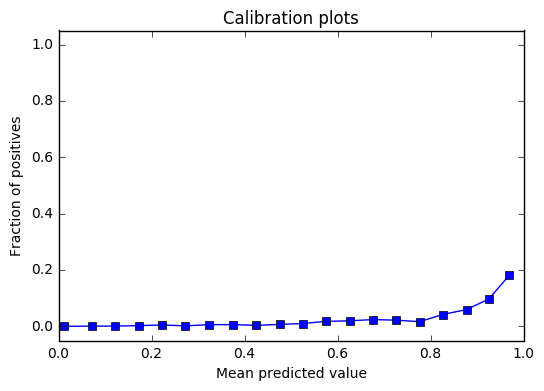

In [152]:
simple_cal_plot(pnu_rep_rf_cal)

## Calibrate the whole model

In [169]:
rf = RandomForestClassifier()
rep = RepeatedRandomSubSampler(base_estimator=rf, verbose=1, n_jobs=-1, voting='soft')
pnu_rep_cal_rf = PNUWrapper(base_estimator=rep, num_unlabeled=1.0)
pnu_rep_cal_rf.set_params(**rr_params)
pnu_rep_cal_rf.set_params(base_estimator=CalibratedClassifierCV(clone(pnu_rep_cal_rf.base_estimator), method='isotonic', cv=2))

PNUWrapper(base_estimator=CalibratedClassifierCV(base_estimator=RepeatedRandomSubSampler(base_estimator=RandomForestClassifier(bootstrap=False, class_weight=None, criterion='gini',
            max_depth=64, max_features=87, max_leaf_nodes=None,
            min_impurity_split=1e-07, min_samples_leaf=1,
            min_samples_split=0.01, min_weight...obs', random_state=None,
             sample_imbalance=0.4406340820472374, verbose=1, voting='soft'),
            cv=2, method='isotonic'),
      num_unlabeled=1.0, pu_learning=True, random_state=None,
      threshold_set_pct=None)

In [170]:
pnu_rep_cal_rf.fit(X_train.values, y_train.values)

generating 93 samples of indices to use to train multiple estimators,               sized 2729 elements with last being 1599 elements


[Parallel(n_jobs=-1)]: Done  42 tasks      | elapsed:    6.6s
[Parallel(n_jobs=-1)]: Done  93 out of  93 | elapsed:   13.1s finished
[Parallel(n_jobs=-1)]: Done  42 tasks      | elapsed:   31.8s
[Parallel(n_jobs=-1)]: Done  93 out of  93 | elapsed:  1.1min finished


generating 93 samples of indices to use to train multiple estimators,               sized 2729 elements with last being 1599 elements


[Parallel(n_jobs=-1)]: Done  42 tasks      | elapsed:    6.8s
[Parallel(n_jobs=-1)]: Done  93 out of  93 | elapsed:   13.7s finished
[Parallel(n_jobs=-1)]: Done  42 tasks      | elapsed:   32.0s
[Parallel(n_jobs=-1)]: Done  93 out of  93 | elapsed:  1.2min finished


PNUWrapper(base_estimator=CalibratedClassifierCV(base_estimator=RepeatedRandomSubSampler(base_estimator=RandomForestClassifier(bootstrap=False, class_weight=None, criterion='gini',
            max_depth=64, max_features=87, max_leaf_nodes=None,
            min_impurity_split=1e-07, min_samples_leaf=1,
            min_samples_split=0.01, min_weight...obs', random_state=None,
             sample_imbalance=0.4406340820472374, verbose=1, voting='soft'),
            cv=2, method='isotonic'),
      num_unlabeled=1.0, pu_learning=True, random_state=None,
      threshold_set_pct=None)

In [171]:
FrankenScorer()(pnu_rep_cal_rf, X_test.values, y_test.values)

[Parallel(n_jobs=-1)]: Done  42 tasks      | elapsed:   16.0s
[Parallel(n_jobs=-1)]: Done  93 out of  93 | elapsed:   34.7s finished
[Parallel(n_jobs=-1)]: Done  42 tasks      | elapsed:   16.0s
[Parallel(n_jobs=-1)]: Done  93 out of  93 | elapsed:   34.7s finished
[Parallel(n_jobs=-1)]: Done  42 tasks      | elapsed:   16.3s
[Parallel(n_jobs=-1)]: Done  93 out of  93 | elapsed:   34.9s finished
[Parallel(n_jobs=-1)]: Done  42 tasks      | elapsed:   16.1s
[Parallel(n_jobs=-1)]: Done  93 out of  93 | elapsed:   34.7s finished


({'SCORE': 0.0,
  'assumed_brier': 0.0043436649248070613,
  'assumed_brier_neg': 0.00042115447364206619,
  'assumed_f1': 0.0,
  'assumed_f1beta10': 0.0,
  'confusion_matrix_lab': array([[214,   1],
         [418,   0]]),
  'confusion_matrix_un': array([[87717,     5],
         [  418,     0]]),
  'labeled_acc': 0.3380726698262243,
  'labeled_avg_prec': 0.33017377567140599,
  'labeled_brier': 0.54821565949674045,
  'labeled_brier_neg': 0.0051832498873102288,
  'labeled_brier_pos': 0.82752658788436628,
  'labeled_f1': 0.0,
  'labeled_prec': 0.0,
  'labeled_recall': 0.0,
  'labeled_roc_auc': 0.49767441860465117,
  'pr_one_unlabeled': 4.5710628863976594e-05,
  'pu_mix_assumed_f1beta10': 0.0,
  'pu_score': 0.0},
 0.0)

[Parallel(n_jobs=-1)]: Done  42 tasks      | elapsed:   16.2s
[Parallel(n_jobs=-1)]: Done  93 out of  93 | elapsed:   35.0s finished
[Parallel(n_jobs=-1)]: Done  42 tasks      | elapsed:   16.3s
[Parallel(n_jobs=-1)]: Done  93 out of  93 | elapsed:   34.9s finished


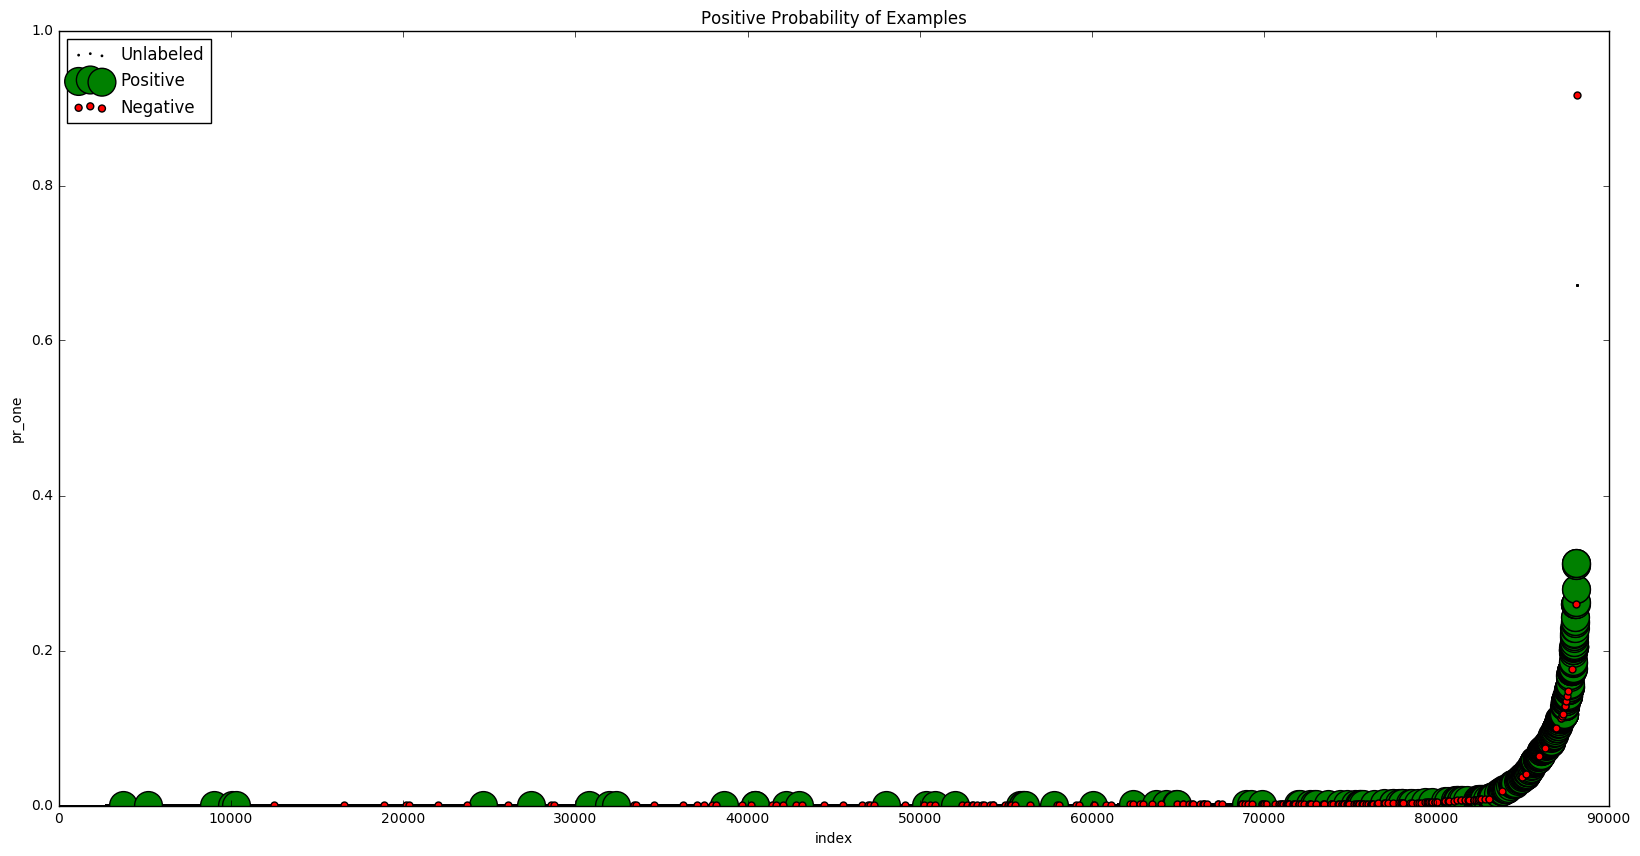

In [172]:
graph_prob(pnu_rep_cal_rf)

[Parallel(n_jobs=-1)]: Done  42 tasks      | elapsed:   16.1s
[Parallel(n_jobs=-1)]: Done  93 out of  93 | elapsed:   34.7s finished
[Parallel(n_jobs=-1)]: Done  42 tasks      | elapsed:   16.1s
[Parallel(n_jobs=-1)]: Done  93 out of  93 | elapsed:   34.7s finished


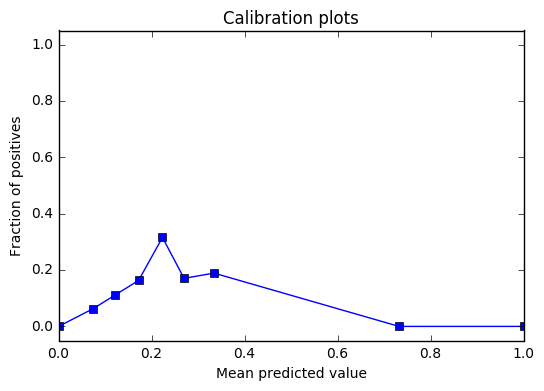

In [173]:
simple_cal_plot(pnu_rep_cal_rf)

In [174]:
pnu_rep_cal_rf.get_params()

{'base_estimator': CalibratedClassifierCV(base_estimator=RepeatedRandomSubSampler(base_estimator=RandomForestClassifier(bootstrap=False, class_weight=None, criterion='gini',
             max_depth=64, max_features=87, max_leaf_nodes=None,
             min_impurity_split=1e-07, min_samples_leaf=1,
             min_samples_split=0.01, min_weight...obs', random_state=None,
              sample_imbalance=0.4406340820472374, verbose=1, voting='soft'),
             cv=2, method='isotonic'),
 'base_estimator__base_estimator': RepeatedRandomSubSampler(base_estimator=RandomForestClassifier(bootstrap=False, class_weight=None, criterion='gini',
             max_depth=64, max_features=87, max_leaf_nodes=None,
             min_impurity_split=1e-07, min_samples_leaf=1,
             min_samples_split=0.01, min_weight_fraction_leaf=0.0,
             n_estimators=10, n_jobs=1, oob_score=False, random_state=None,
             verbose=0, warm_start=False),
              n_jobs=-1, pre_dispatch='2*n_jobs'

In [175]:
type(pnu_rep_cal_rf)

pnuwrapper.PNUWrapper

In [168]:
probs

array([ 0.00034019,  0.00034019,  0.00034019, ...,  0.1943718 ,
        0.19803902,  0.19950441])